# Построение mel-спектрограммы

## Читаем аудиосигнал

In [1]:
import numpy as np
import soundfile as sf

filename = 'audio_input_4.wav'
signal, fs = sf.read(filename)

Посмотрим на число каналов

In [2]:
print(signal.ndim)

2


In [3]:
if signal.ndim > 1:
    signal = signal[:, 0]

Применим pre‑emphasis

In [4]:
alpha = 0.97
emphasized = np.append(signal[0], signal[1:] - alpha * signal[:-1])

## Окно Ханна

In [5]:
frame_length_ms = 25
frame_step_ms = 10

# Переводим ms в количество сэмплов
L = int(frame_length_ms * fs * 10**-3)
H = int(frame_step_ms * fs * 10**-3)

# Считаем кол-во окон
num_frames = int((len(emphasized) - L) / H)
window = np.hanning(L)

# БПФ
NFFT = 2** int(np.log2(L))
K = NFFT // 2


power_spectr = np.zeros((num_frames, K + 1))
for i in range(num_frames):
    start = i * H
    frame = emphasized[start:start + L]
    frame_window = frame * window
    spectr = np.fft.rfft(frame_window, n=NFFT)
    power = (np.abs(spectr) ** 2) / NFFT
    power_spectr[i, :] = power

print(f'Кол-во фреймов: {num_frames}, NFFT: {NFFT}')

Кол-во фреймов: 338, NFFT: 1024


## Шкала mel

In [6]:
M = 80
fmin = 20.0
fmax = fs / 2.0

def hz_to_mel(f):
    return 2595.0 * np.log10(1 + f / 700.0)

def mel_to_hz(m):
    return 700.0 * (10**(m / 2595.0) - 1)

mel_min = hz_to_mel(fmin)
mel_max = hz_to_mel(fmax)
mel_points = np.linspace(mel_min, mel_max, M + 2)
hz_points = mel_to_hz(mel_points)

arr_freq = np.linspace(0, fs / 2, K + 1)

filter_save = np.zeros((M, K + 1))
for m in range(1, M + 1):
    f_left, f_center, f_right = hz_points[m - 1], hz_points[m], hz_points[m + 1]
    left = (arr_freq >= f_left) & (arr_freq <= f_center)
    right = (arr_freq >= f_center) & (arr_freq <= f_right)
    filter_save[m - 1, left] = (arr_freq[left] - f_left) / (f_center - f_left)
    filter_save[m - 1, right] = (f_right - arr_freq[right]) / (f_right - f_center)

mel_energy = filter_save.dot(power_spectr.T)

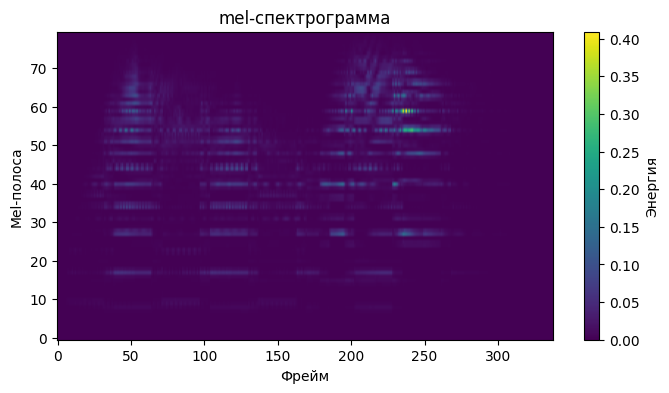

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.imshow(mel_energy, origin='lower', aspect='auto')
plt.xlabel('Фрейм')
plt.ylabel('Mel‑полоса')
plt.title('mel‑спектрограмма')
plt.colorbar(label='Энергия')
plt.show()

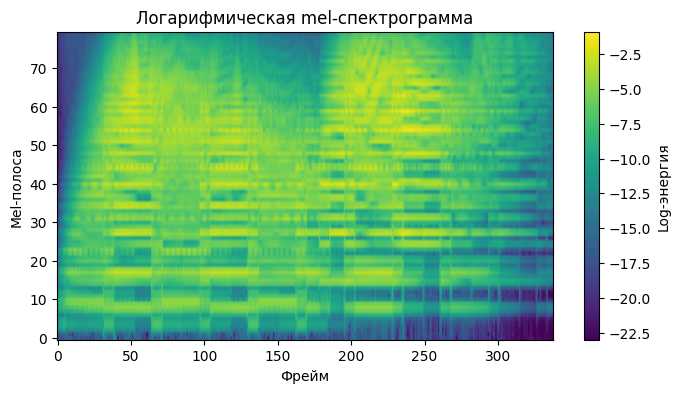

In [8]:
eps = 1e-10
mel_log = np.log(mel_energy + eps)

plt.figure(figsize=(8, 4))
plt.imshow(mel_log, origin='lower', aspect='auto')
plt.xlabel('Фрейм')
plt.ylabel('Mel‑полоса')
plt.title('Логарифмическая mel‑спектрограмма')
plt.colorbar(label='Log‑энергия')
plt.show()